## Import libraries

In [1]:
library("tidyverse")
library("lubridate")
library("leaflet")
library("zoo")
library("forecast")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.z

## Import data

In [2]:
nypd_shooting_data <- read_csv("https://data.cityofnewyork.us/api/views/833y-fsy8/rows.csv?accessType=DOWNLOAD")

Parsed with column specification:
cols(
  INCIDENT_KEY = col_double(),
  OCCUR_DATE = col_character(),
  OCCUR_TIME = col_time(format = ""),
  BORO = col_character(),
  PRECINCT = col_double(),
  JURISDICTION_CODE = col_double(),
  LOCATION_DESC = col_character(),
  STATISTICAL_MURDER_FLAG = col_logical(),
  PERP_AGE_GROUP = col_character(),
  PERP_SEX = col_character(),
  PERP_RACE = col_character(),
  VIC_AGE_GROUP = col_character(),
  VIC_SEX = col_character(),
  VIC_RACE = col_character(),
  X_COORD_CD = col_double(),
  Y_COORD_CD = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Lon_Lat = col_character()
)


## Format variables

In [3]:
nypd_shooting_data <-nypd_shooting_data %>% mutate(OCCUR_DATE=mdy(OCCUR_DATE))

In [4]:
cols_to_keep <- c("OCCUR_DATE",
                  "OCCUR_TIME",
                  "BORO",
                  "PRECINCT",
                  "LOCATION_DESC",
                  "STATISTICAL_MURDER_FLAG",
                  "PERP_AGE_GROUP",
                  "PERP_SEX",
                  "PERP_RACE",
                  "VIC_AGE_GROUP",
                  "VIC_SEX",
                  "VIC_RACE",
                  "Latitude",
                  "Longitude"
                 )

In [5]:
nypd_shooting_data <- nypd_shooting_data %>% select(cols_to_keep)

In [6]:
clasify_location <- function(location) {
    if((location =="NONE") | is.na(location)){
        return("NA")
    } 
    if(location %in% c("BANK","CHECK CASH","LOAN COMPANY","ATM","")){
        return("Financial_institution")
    }
    if(location %in% c("MULTI DWELL - PUBLIC HOUS","MULTI DWELL - APT BUILD","PVT HOUSE")){
        return("Housing")
    }
    if(location %in% c("DOCTOR/DENTIST","GYM/FITNESS FACILITY","HOSPITAL",
                       "SCHOOL","HOTEL/MOTEL","SOCIAL CLUB/POLICY LOCATI",
                       "BAR/NIGHT CLUB","FACTORY/WAREHOUSE","STORAGE FACILITY")){
        return("Other")
    }
    if(location %in% c("GROCERY/BODEGA","FAST FOOD","COMMERCIAL BLDG","RESTAURANT/DINER",
                       "CLOTHING BOUTIQUE","SMALL MERCHANT","LIQUOR STORE","SUPERMARKET",
                       "BEAUTY/NAIL SALON","SHOE STORE","DRY CLEANER/LAUNDRY","DEPT STORE",
                       "GAS STATION","PHOTO/COPY STORE","VIDEO STORE","STORE UNCLASSIFIED",
                       "CHAIN STORE","DRUG STORE","TELECOMM. STORE","JEWELRY STORE",
                       "CANDY STORE","VARIETY STORE")){
        return("Commercial")
    }
    return("Otro no encontrado")
    
}

In [7]:
nypd_shooting_data["LOCATION_DESC"] <-nypd_shooting_data["LOCATION_DESC"] %>% apply(1,clasify_location)

In [8]:
distinct(nypd_shooting_data['LOCATION_DESC'])

LOCATION_DESC
NA
Housing
Commercial
Other
Financial_institution


In [9]:
clasify_age_group <- function(age_group) {
    if((age_group =="UNKNOWN") | is.na(age_group)){
        return("UNKNOWN")
    } 
    if(age_group %in% c("<18","18-24","25-44","45-64","65+")){
        return(age_group)
    }
    return("UNKNOWN")
    
}

In [10]:
nypd_shooting_data["PERP_AGE_GROUP"] <-nypd_shooting_data["PERP_AGE_GROUP"] %>% apply(1,clasify_age_group)

In [11]:
distinct(nypd_shooting_data['PERP_AGE_GROUP'])

PERP_AGE_GROUP
UNKNOWN
18-24
25-44
<18
45-64
65+


In [12]:
nypd_shooting_data["VIC_AGE_GROUP"] <-nypd_shooting_data["VIC_AGE_GROUP"] %>% apply(1,clasify_age_group)

In [13]:
distinct(nypd_shooting_data['VIC_AGE_GROUP'])

VIC_AGE_GROUP
25-44
65+
18-24
<18
45-64
UNKNOWN


In [14]:
clean_sex <- function(sex) {
    if(sex %in% c("M","F")){
        return(sex)
    }
    return("U")
    
}

In [15]:
nypd_shooting_data["VIC_SEX"] <-nypd_shooting_data["VIC_SEX"] %>% apply(1,clean_sex)

In [16]:
distinct(nypd_shooting_data['VIC_SEX'])

VIC_SEX
F
M
U


In [17]:
nypd_shooting_data["PERP_SEX"] <-nypd_shooting_data["PERP_SEX"] %>% apply(1,clean_sex)

In [18]:
distinct(nypd_shooting_data['PERP_SEX'])

PERP_SEX
U
M
F


In [19]:
clean_race <- function(race) {
    if(is.na(race)){
        return("UNKNOWN")
    }
    return(race)
    
}

In [20]:
nypd_shooting_data["PERP_RACE"] <-nypd_shooting_data["PERP_RACE"] %>% apply(1,clean_race)

In [21]:
distinct(nypd_shooting_data['PERP_RACE'])

PERP_RACE
UNKNOWN
BLACK
WHITE HISPANIC
WHITE
ASIAN / PACIFIC ISLANDER
BLACK HISPANIC
AMERICAN INDIAN/ALASKAN NATIVE


In [22]:
distinct(nypd_shooting_data['VIC_RACE'])

VIC_RACE
BLACK HISPANIC
WHITE
BLACK
WHITE HISPANIC
AMERICAN INDIAN/ALASKAN NATIVE
UNKNOWN
ASIAN / PACIFIC ISLANDER


In [23]:
get_hour <- function(time) {
    return(hour(hms(time))) 
}

In [24]:
nypd_shooting_data['OCCUR_HOUR'] <- nypd_shooting_data["OCCUR_TIME"] %>% apply(1,get_hour)

In [25]:
cases_by_day <- nypd_shooting_data %>%  count(OCCUR_DATE)

In [26]:
cases_by_day['month_ma'] <- rollmean(cases_by_day['n'],30,c(NA,NULL,NA))

In [27]:
cases_by_day['year_ma'] <- rollmean(cases_by_day['n'],365,c(NA,NULL,NA))

Warning message:
“Removed 29 rows containing missing values (geom_path).”Warning message:
“Removed 364 rows containing missing values (geom_path).”

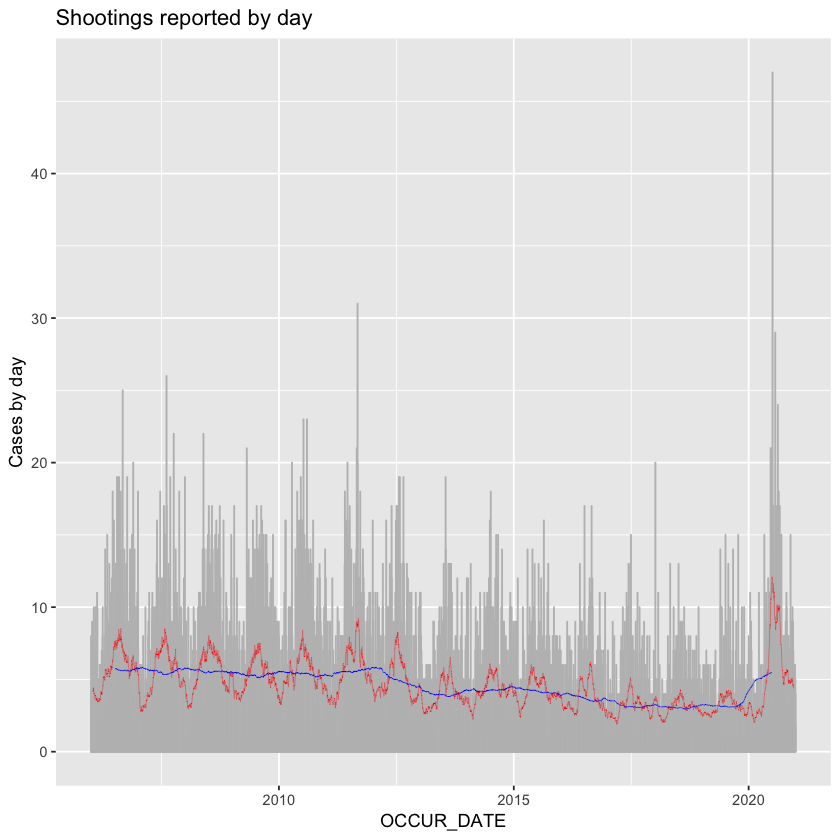

In [28]:
ggplot(aes(x=OCCUR_DATE,y=n),data=cases_by_day) +
  geom_col(color="grey")+
  geom_line(aes(y = month_ma), color = "red", size = 0.1)+ 
  geom_line(aes(y = year_ma), color = "blue", size = 0.1)+ 
  labs(y='Cases by day',title="Shootings reported by day")

In [29]:
cases_by_day['OCCUR_MONTH'] <- cases_by_day['OCCUR_DATE'] %>% apply(1,month)
cases_by_day['OCCUR_YEAR'] <- cases_by_day['OCCUR_DATE'] %>% apply(1,year)

In [30]:
# As 2020 is atypical lets filter it to analyze average cases per day
average_cases_by_month <- cases_by_day %>% filter(OCCUR_YEAR != 2020) %>% 
    group_by(OCCUR_MONTH) %>% summarise(cases=mean(n))
average_cases_by_year <- cases_by_day %>% filter(OCCUR_YEAR != 2020) %>% 
    group_by(OCCUR_YEAR) %>% summarise(cases=mean(n))

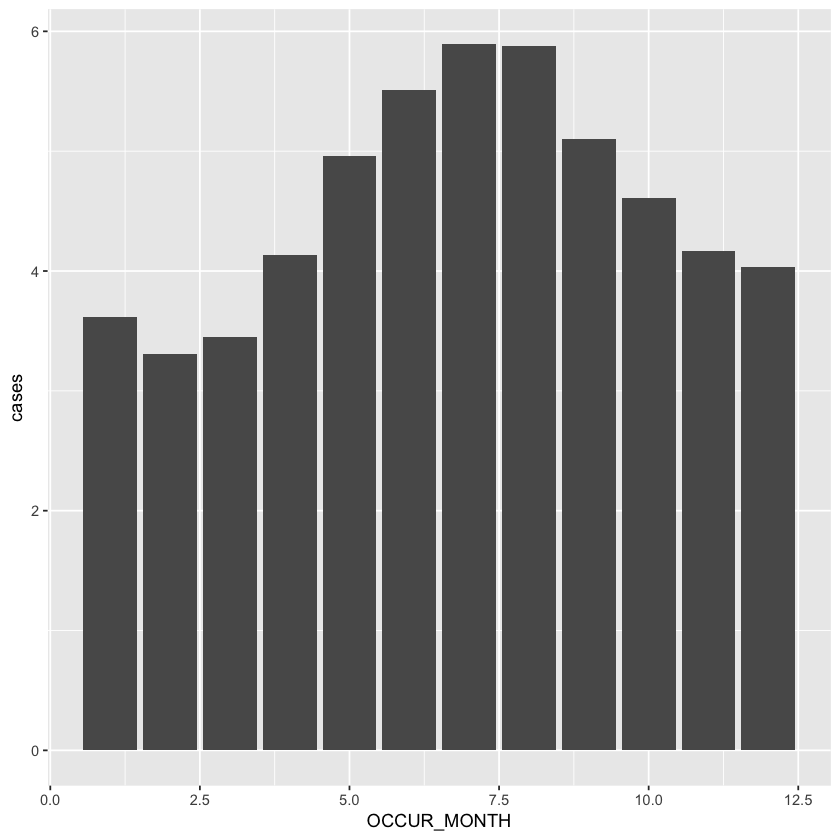

In [31]:
ggplot(aes(x=OCCUR_MONTH,y=cases),data=average_cases_by_month) +
  geom_col()

In [32]:
average_cases_by_month

OCCUR_MONTH,cases
1,3.617949
2,3.307229
3,3.448187
4,4.130890
5,4.956204
6,5.510050
7,5.890736
8,5.878282
9,5.100251
10,4.606965


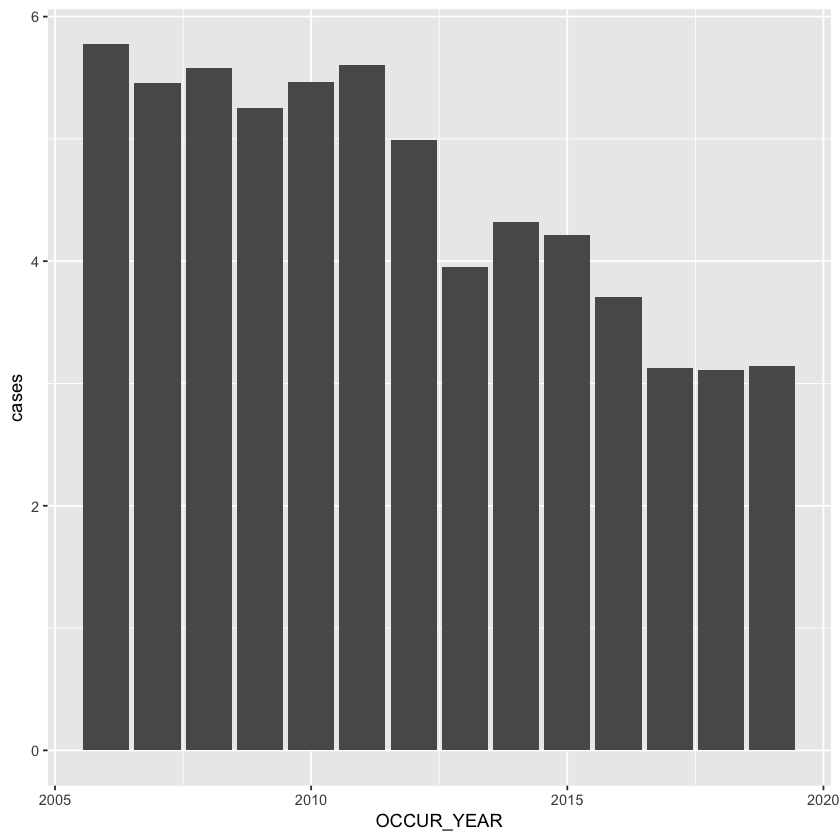

In [33]:
ggplot(aes(x=OCCUR_YEAR,y=cases),data=average_cases_by_year) +
  geom_col()

In [103]:
cases_by_day_model <- cases_by_day %>% filter(OCCUR_YEAR < 2020)

In [222]:
cases_by_day_model_ts <- ts(zoo(cases_by_day_model$n, order.by=cases_by_day_model$OCCUR_DATE),frequency=365)

In [223]:
decomposed_series <- decompose(cases_by_day_model_ts)

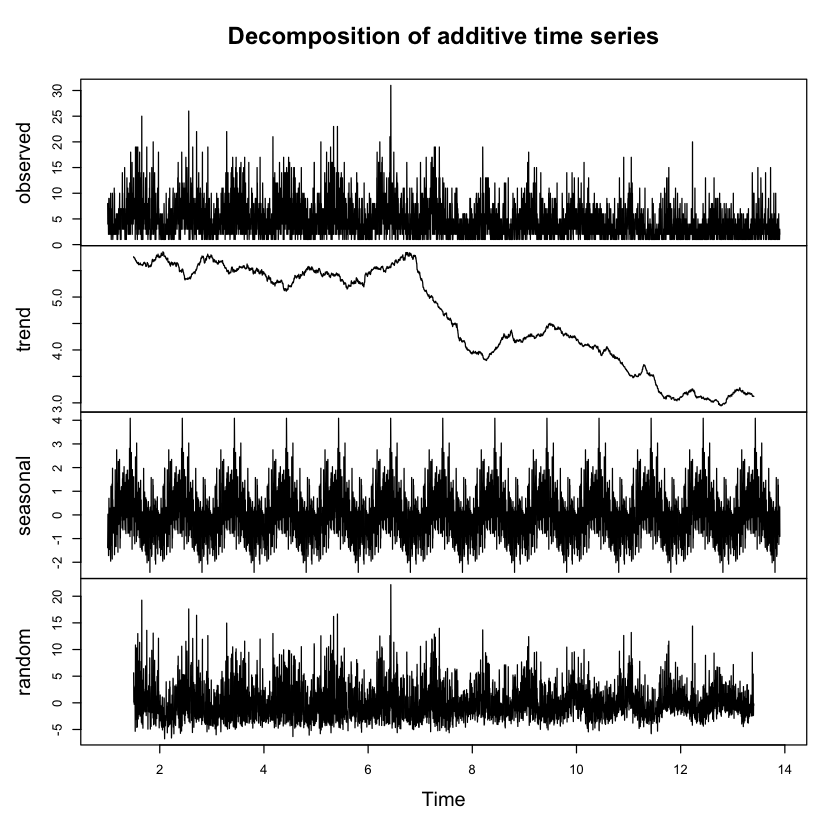

In [224]:
plot(decomposed_series)

In [215]:
model_fit <- auto.arima(cases_by_day_model_ts,stepwise=FALSE)


	Ljung-Box test

data:  Residuals from ARIMA(2,1,3)
Q* = 1114.1, df = 725, p-value < 2.2e-16

Model df: 5.   Total lags used: 730



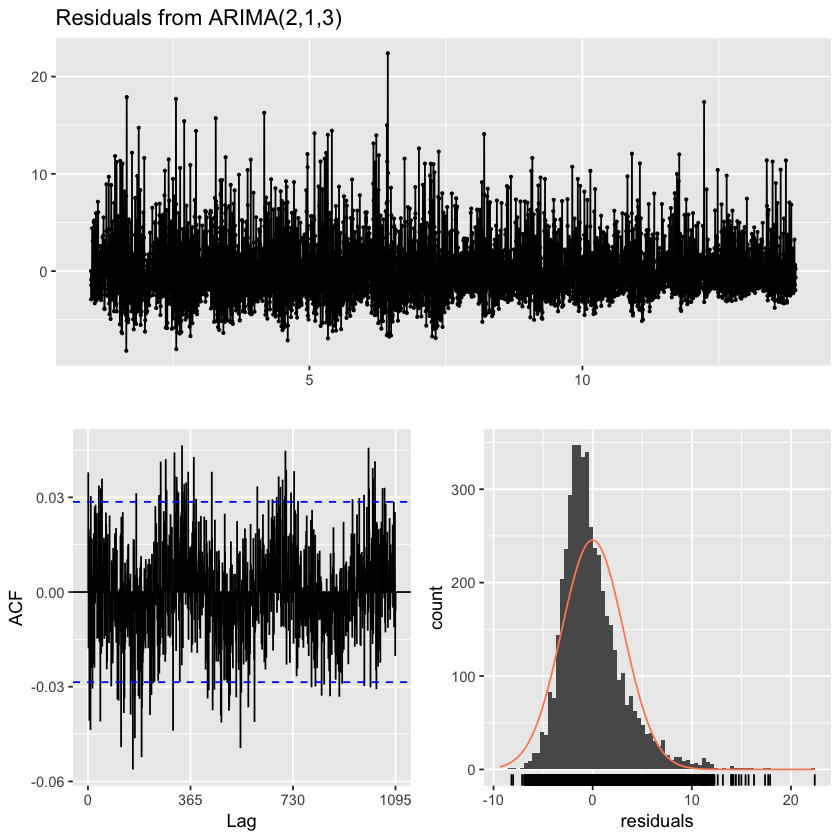

In [216]:
checkresiduals(model_fit)

In [245]:
library("prophet")

In [271]:
cases_by_day_ph <- cases_by_day %>% select(c("OCCUR_DATE","n"))

In [272]:
colnames(cases_by_day_ph) <- c("ds","y")

In [273]:
prophet_model <- prophet(changepoint.prior.scale=1)
prophet_model <- add_country_holidays(prophet_model, country_name = 'US')
prophet_model <- fit.prophet(prophet_model,cases_by_day_ph)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


In [274]:
future <- make_future_dataframe(prophet_model, periods = 365)

In [275]:
forecast <- predict(prophet_model, future)

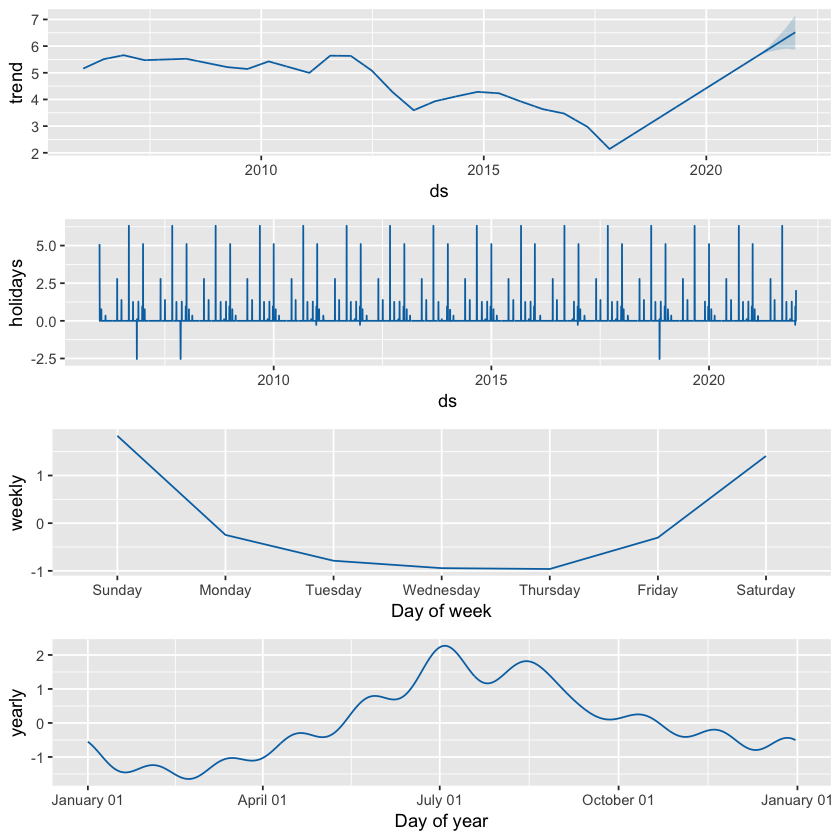

In [276]:
prophet_plot_components(prophet_model,forecast)

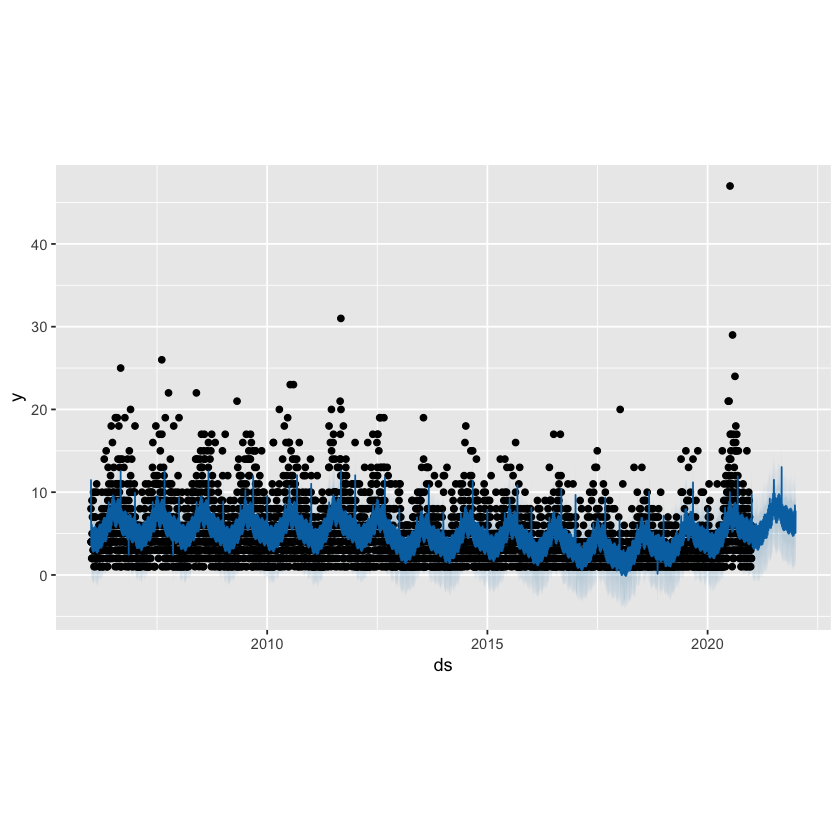

In [277]:
plot(prophet_model, forecast)

In [264]:
cases_by_day_ph <- cases_by_day %>% filter(OCCUR_YEAR < 2020) %>% select(c("OCCUR_DATE","n"))

In [265]:
colnames(cases_by_day_ph) <- c("ds","y")

In [266]:
prophet_model <- prophet(changepoint.prior.scale=1)
prophet_model <- add_country_holidays(prophet_model, country_name = 'US')
prophet_model <- fit.prophet(prophet_model,cases_by_day_ph)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


In [267]:
future <- make_future_dataframe(prophet_model, periods = 365)

In [268]:
forecast <- predict(prophet_model, future)

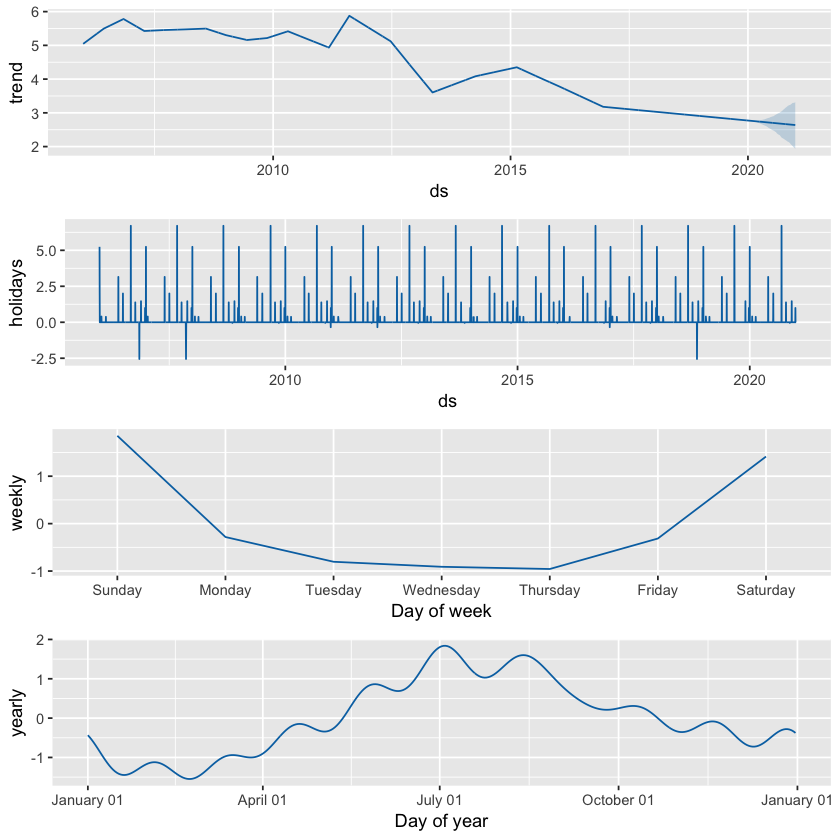

In [269]:
prophet_plot_components(prophet_model,forecast)

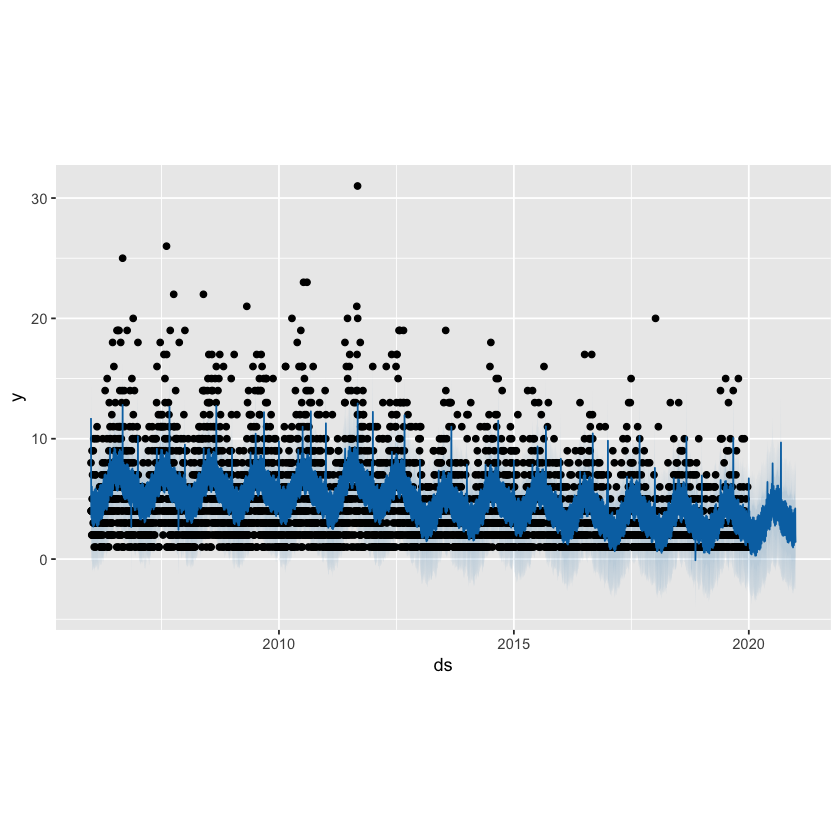

In [270]:
plot(prophet_model, forecast)

In [4]:
map_incidents<-nypd_shooting_data %>%
  select("Latitude","Longitude") %>%
  rename("lat" = "Latitude") %>%
  rename("long"="Longitude") %>%
  leaflet( width = 900) %>%
  addTiles() %>% #urlTemplate = 'http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png'
  addMarkers(clusterOptions = markerClusterOptions())

In [5]:
map_incidents 

HTML widgets cannot be represented in plain text (need html)

In [10]:
%htmlwidgets inline

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected input
1: %htmlwidgets inline
    ^


In [6]:
class(map_incidents)

[1] "leaflet"    "htmlwidget"

In [6]:
nypd_shooting_data %>%
  select("Latitude","Longitude") %>% data.frame

Latitude,Longitude
40.86906,-73.87963
40.67737,-73.84392
40.67489,-73.96008
40.80880,-73.91618
40.59780,-73.79469
40.63359,-73.93715
40.67186,-73.93779
40.68773,-73.93749
40.59404,-73.75778
40.67348,-73.80540


In [4]:
nypd_shooting_data

INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
24050482,2006-08-27,05:35:00,BRONX,52,0,NA,TRUE,NA,NA,NA,25-44,F,BLACK HISPANIC,1017541.6,255918.9,40.86906,-73.87963,POINT (-73.87963173099996 40.86905819000003)
77673979,2011-03-11,12:03:00,QUEENS,106,0,NA,FALSE,NA,NA,NA,65+,M,WHITE,1027543.0,186095.0,40.67737,-73.84392,POINT (-73.84392019199998 40.677366895000034)
203350417,2019-10-06,01:09:00,BROOKLYN,77,0,NA,FALSE,NA,NA,NA,18-24,F,BLACK,995325.0,185155.0,40.67489,-73.96008,POINT (-73.96007501899999 40.674885741000026)
80584527,2011-09-04,03:35:00,BRONX,40,0,NA,FALSE,NA,NA,NA,<18,M,BLACK,1007453.0,233952.0,40.80880,-73.91618,POINT (-73.91618413199996 40.80879780500004)
90843766,2013-05-27,21:16:00,QUEENS,100,0,NA,FALSE,NA,NA,NA,18-24,M,BLACK,1041267.4,157133.5,40.59780,-73.79469,POINT (-73.79468553799995 40.597796249000055)
92393427,2013-09-01,04:17:00,BROOKLYN,67,0,NA,FALSE,NA,NA,NA,<18,M,BLACK,1001693.9,170112.9,40.63359,-73.93715,POINT (-73.93715330699996 40.63358818100005)
73057167,2010-06-05,21:16:00,BROOKLYN,77,0,NA,FALSE,NA,NA,NA,<18,M,BLACK,1001506.8,184055.7,40.67186,-73.93779,POINT (-73.93779204599997 40.67185839800004)
211362213,2020-03-20,21:27:00,BROOKLYN,81,0,NA,FALSE,NA,NA,NA,25-44,M,BLACK,1001586.4,189839.0,40.68773,-73.93749,POINT (-73.93749012499995 40.68773229400006)
137564752,2014-07-04,00:25:00,QUEENS,101,0,NA,FALSE,NA,NA,NA,18-24,M,BLACK,1051520.4,155790.4,40.59404,-73.75778,POINT (-73.75777869199999 40.59403780700006)
147024011,2015-10-18,01:33:00,QUEENS,106,0,NA,FALSE,NA,NA,NA,18-24,M,BLACK,1038231.3,184701.4,40.67348,-73.80540,POINT (-73.80539763499996 40.67348312300004)
